In [79]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [116]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

In [81]:
import datetime as dt
import random

# Reflect Tables into SQLAlchemy ORM

In [82]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [83]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [84]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [85]:
# We can view all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [86]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station
#print(Station)

In [87]:
#Creating inspector to look at table information
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
s_columns = inspector.get_columns('station')
for m in m_columns:
    print(m['name'])
print("\n")
for s in s_columns:
    print(s['name'])

id
station
date
prcp
tobs


id
station
name
latitude
longitude
elevation


In [88]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

[(0.0, '2017-08-23'), (0.0, '2017-08-23'), (0.08, '2017-08-23'), (0.45, '2017-08-23'), (0.0, '2017-08-22')]
<class 'datetime.datetime'>


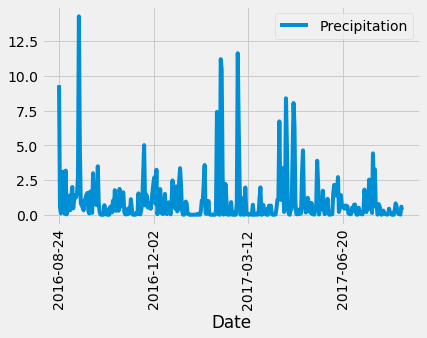

In [129]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Figure out the last date present in the dataset
print(session.query(Measurement.prcp, Measurement.date).order_by(Measurement.date.desc()).limit(5).all())


# Calculate the date 1 year ago from the last data point in the database
first = dt.datetime.strptime('2017-08-23', '%Y-%m-%d') - dt.timedelta(days=365)
print(type(first))
# Perform a query to retrieve the data and precipitation scores
part1_q = session.query(Measurement.date, func.sum(Measurement.prcp)).filter(Measurement.date >= first).\
    group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
part1 = pd.DataFrame(part1_q, columns=['Date', 'Precipitation'])
#part1['Date'] = pd.to_datetime(part1['Date'])
#print(part1.info())
part1.set_index('Date', inplace=True)

part1.plot()
plt.xlabel(xlabel='Date')
plt.tight_layout()
plt.xticks(rotation='vertical')
plt.savefig("../Output/Precipiation Line Graph")
plt.show()

In [90]:
# Use Pandas to calcualte the summary statistics for the precipitation data
part1.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [91]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).limit(15).all()

[(9)]

In [92]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_act_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_act_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station = most_act_station[0][0]
temp_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f"Temp Stats for Station {station} is\nMin: {temp_min[0][0]}\nMax: {temp_max[0][0]}\nAverage: {round(temp_avg[0][0], 2)}")

Temp Stats for Station USC00519281 is
Min: 54.0
Max: 85.0
Average: 71.66


In [94]:
# Choose the station with the highest number of temperature observations.
most_temp_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
most_temp_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [95]:
#Testing out building query for most recent date with tob information
#Select the stations from the query above
station_temp = most_temp_station[0][0]

stat_temp = session.query(Measurement.date).filter(Measurement.station == station_temp).order_by(Measurement.date.desc()).limit(1).all()[0][0]
print(stat_temp)

2017-08-18


In [96]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Calculate the date 1 year ago from the last data point in the database
temp_date = dt.datetime.strptime(stat_temp, '%Y-%m-%d') - dt.timedelta(days=365)

print(stat_temp+"\n"+temp_date.strftime("%Y\t%m\t%d"))


2017-08-18
2016	08	18


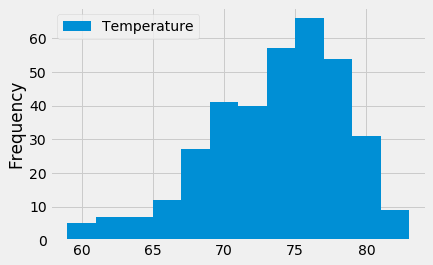

In [128]:

# Perform a query to retrieve the data and precipitation scores
sta_temp_q = session.query(Measurement.tobs, Measurement.date).filter(Measurement.date >= temp_date).filter(Measurement.station == station_temp).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
final = pd.DataFrame(sta_temp_q, columns=['Temperature', 'Date'])
final.set_index('Date', inplace=True)
final.plot.hist(bins=12)
plt.savefig("../Output/Temp Histogram")
plt.show()

Bonus

In [126]:
# Identify the average temperature in June at all stations across all available years in the dataset. 

june = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date)=='06').limit(15).all()
type(june[0][0])

float

In [125]:
# Do the same for December temperature.
dec = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date)=='12').limit(15).all()
type(dec[0][0])

float

In [122]:
ttest_ind(june[0][0], dec[0][0])

Ttest_indResult(statistic=nan, pvalue=nan)

Seems that we would use a paried 2 test since we would be comparing the same subject at different points of time

In [98]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [99]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startd = '2017-02-28'
endd = '2017-03-05'
ct_holder = calc_temps(startd, endd)
print(ct_holder)

[(64.0, 72.02777777777777, 78.0)]


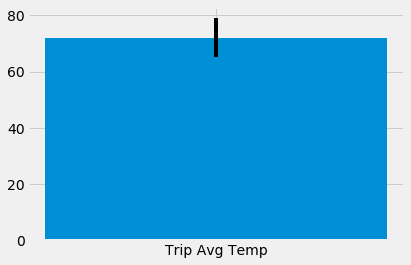

In [127]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# So I thought about using the data for peak to peak but it didnt seem like a true reprentation of the data
# that was displayed. Tip to tip would have been 14 so i used half of that which seemed to match more with
# the data
plt.bar("Trip Avg Temp", ct_holder[0][1], yerr=7)
plt.savefig("../Output/Trip Avg Temp")
plt.show()

In [101]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
pre_year_start = dt.datetime.strptime(startd, '%Y-%m-%d') - dt.timedelta(days=365)
print(pre_year_start)
pre_year_end = dt.datetime.strptime(endd, '%Y-%m-%d') - dt.timedelta(days=365)
session.query(func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.station == Station.station).filter(Measurement.date >= pre_year_start).filter(Measurement.date <= pre_year_end).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

2016-02-29 00:00:00


[(0.33,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.07,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (0.02,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (0.01,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.0, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [102]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(func.strftime("%m-%d", Measurement.date) == "01-01").all()

[(62.0, 69.15384615384616, 77.0)]

In [103]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [108]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
dates = []
start_d = dt.datetime.strptime(startd, '%Y-%m-%d')
#print(start_d)
end_d = dt.datetime.strptime(endd, '%Y-%m-%d')
#print(end_d)
time_shift = dt.timedelta(days=1)
while start_d <= end_d:
    print(start_d.strftime("%m-%d"))
    #print(daily_normals(start_d.strftime("%m-%d")))
    dates.append(start_d.strftime("%m-%d"))
    normals.append(daily_normals(start_d.strftime("%m-%d"))[0])
    start_d += time_shift
print(normals)
print(dates)
session.close()

02-28
03-01
03-02
03-03
03-04
03-05
[(65.0, 70.65517241379311, 80.0), (64.0, 70.0327868852459, 76.0), (61.0, 70.36666666666666, 78.0), (60.0, 70.06896551724138, 78.0), (57.0, 69.27272727272727, 77.0), (60.0, 67.89090909090909, 76.0)]
['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']


In [107]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dn = pd.DataFrame(normals, columns=['Lows', 'Avg', 'Highs'])
dn['Dates'] = dates
dn.set_index('Dates', inplace=True)
dn

,Lows,Avg,Highs
Dates,,,
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


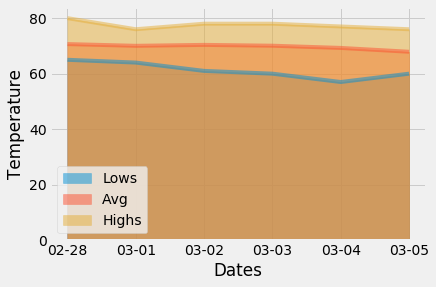

In [130]:
# Plot the daily normals as an area plot with `stacked=False`
dn.plot.area(stacked=False)
plt.ylabel('Temperature')
plt.savefig("../Output/Temp Area Chart")
plt.show()